## Data Acquisition

In [37]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import requests
import json
import pprint
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
from scipy.stats import norm
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pandas.plotting import scatter_matrix

In [1]:
# creating full urls from base and tails that do not appear in html of main page (allows us to avoid clicking through to sub-urls)
hunt_code = []
short_url = 'https://dwrapps.utah.gov/huntboundary/HaNumber'
hunt_nums_EB = list(range(3000,3129))  #hard code list of limited entry elk hunt numbers

for each in hunt_nums_EB:
    string_EB = str(each)   # change each hunt number int to str for concatenation purposes
    letters_EB = '?hn=EB' + string_EB   # concatenate hunt letter abbreviations with hunt numbers to create full hunt code
    hunt_code.append(short_url + letters_EB)

# creating empty lists of parameters of interests for later population
hunt_number = []
hunt_type = []
species = []
unit_name = []
weapon_type = []
season_dates = []
percent_harvest = []
pop_obj = []
current_pop = []
age_obj = []
current_age = []

# extracting data from urls
for i in hunt_code:
    res = requests.get(i)
    hunt = json.loads(res.text) 

    ### huntBios key
    res.headers['content-type']
    pagedata = res.content.decode("utf-8")
    hunt_num_json = json.loads(pagedata)
    huntBios = hunt_num_json['huntBios'][0]
    man_obj = huntBios['MANAGEMENT_OBJ']
    split = man_obj.split('~') # relevant information is contained in string; splitting string to useable elements
    # creating perent_harvest, pop_obj, current_pop, age_obj, current_age lists by splitting string correctly
    percent_harvest.append(split[0])
    pop_obj.append(split[1])
    current_pop.append(split[2])
    age_obj.append(split[5])
    current_age.append(split[6])
    

    ### huntMaster key
    # creating unit_name, hunt_number_hunt_type, species, and weapon_type lists from huntMaster key
    huntMaster = hunt_num_json['huntMaster']
    unit_name.append(huntMaster['HUNT_NAME'])
    hunt_number.append(huntMaster['HUNT_NBR'])
    hunt_type.append(huntMaster['HUNT_TYPE'])
    species.append(huntMaster['SPECIES'])
    weapon_type.append(huntMaster['WEAPON'])


    ### huntYears key
    # creating season_dates list from the huntYears key
    huntYears = hunt_num_json['huntYears']
    huntYears0 = (huntYears[0])
    szn = huntYears0['SEASON_DATE_TEXT']
    season_dates.append(szn)

# creating dataframe from lists created in last step
df=pd.DataFrame()
df['Unit_Name']=unit_name
df['Hunt_Number']=hunt_number
df['Type']=hunt_type
df['Species']=species
df['Season_Dates']=season_dates
df['Weapon']=weapon_type
df['Hunter_Success']=percent_harvest
df['Pop_Objective']=pop_obj
df['Current_Pop']=current_pop
df['Age_Objective']=age_obj
df['Current_Age']=current_age



## Data Cleaning
Cleaning our data required programming and manual cleaning. Some strings have extra characters that need to be extracted.  Some string data needs to be converted to int or float types. Also, columns need to be added that account for each hunt's time of year, length of season, and each unit's distance from Salt Lake City.

To obtain data for each hunt's **time of year**, we took the first and last possible days to hunt any season (Aug 17 and January 31). From this data, we found the total hunting year to be 168 days long.  For each hunt, we then took the average day of the hunt and normalized that hunt day over the length of the hunt year. This produced a value from 0 to 1 that corresponded to the hunt season's timing during the overall hunt year.  Small values indicate a hunt season at the very beginning of the hunt year, while larger values indicate a hunt season later in the hunt year. This allowed us to explore how **time of year affects a hunt**. 

To obtain data for proximity to Salt Lake City, we took an image of the Utah Hunt Map and analyzed it in NIH's ImageJ software. In ImageJ, we could find coordinates for the center of each hunting unit, as well as coordinates for downtown Salt Lake City. We then used those coordinates to calculate straigh line distance from SLC to the center of the unit.


Several variables from the scraped data required handing cleaning. The Wasatch Range had populations split among several subregions, so the new data reflects the total population. Certain hunts were missing data, but due to the repetive nature of the data set, we were able to fill in holes using data from other hunts in the same region. In some hunts, letters were added to numerical values match the raw data from other hunts. This was to streamline the automatic cleaning.

This data is saved into a new excel sheet from what was exported during scraping. The new spreadsheet was then loaded back into the notebook and then automatically cleaned. Three processes occured, the first was the removal of the letters from numerical values. The second was the averaging of range esitamtes. These ranges were were split into the upper and lower values then averagred. Finally, all numerical values were converted into floats. 

In [3]:
df.head(20)
print(type(df['Pop_Objective'][18]))
print(df['Pop_Objective'][18])
 
df.to_excel('check1.xlsx')
#manually cleaning
# Organize the data by unit name or population estimates. 
#We need to clean the wasatch range data, and then and populations that have a XXX-XXX format.I just take an average to the two
#values. I recommend delete the index column as well. 
#127 is missing a current age value. I copied it from other hunts in the same region. 


#fd is seperate from df. This means we wont have to scrape everytime we want to adjust the code.

############################## put in a markdown cell

<class 'str'>
5000-5900


In [2]:
fd = pd.read_excel(r'check.xlsx', index=False)
#fd.head()

#automatic data cleaning

for j in range(0,len(fd)):
    
    #first, get rid of any characters in the population data set (e.i. 1700 (Entire Beaver unit))
    fd['Pop_Objective'][j]= ''.join(i for i in fd['Pop_Objective'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    fd['Pop_Objective'][j] = float(fd['Pop_Objective'][j])
    fd['Current_Pop'][j]= ''.join(i for i in fd['Current_Pop'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    
    #get rid of the ranges of data (i.e. 1200-1500)
    #instead we take the average value of the range (1200-1500 ----> 1350)
    fd['Current_Pop'][j] = float(fd['Current_Pop'][j])
    q = fd['Age_Objective'][j]
    q = q.split('–')
    #idk what that is, but its not a minus sign
    q[0] = float(q[0])
    q[1] = float(q[1])
    fd['Age_Objective'][j] = sum(q)/len(q)

#set the relevant groups to float dtype from objective dtype    
fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']]=fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']].astype(float)

fd.head(20)

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Patrick\Anaconda3\lib\site

,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
0,"Beaver, East",EB3102,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1050.0,1450.0,7.75,7.5,0.226190,57,467
1,"Beaver, East",EB3000,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,57.1,1050.0,1450.0,7.75,7.5,0.086310,27,467
2,"Beaver, East",EB3025,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.529762,9,467
3,"Beaver, East",EB3024,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.196429,9,467
4,"Beaver, East",EB3077,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,75.0,1050.0,1450.0,7.75,7.5,0.261905,11,467
5,"Book Cliffs, Bitter Creek/South",EB3103,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,85.7,7500.0,6300.0,6.75,7.2,0.226190,57,417
6,"Book Cliffs, Bitter Creek/South",EB3001,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,39.5,7500.0,6300.0,6.75,7.2,0.086310,27,417
7,"Book Cliffs, Bitter Creek/South",EB3027,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,59.5,7500.0,6300.0,6.75,7.2,0.529762,9,417
8,"Book Cliffs, Bitter Creek/South",EB3026,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,81.4,7500.0,6300.0,6.75,7.2,0.196429,9,417
9,"Book Cliffs, Bitter Creek/South",EB3078,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,92.0,7500.0,6300.0,6.75,7.2,0.261905,11,417


### Initial Data Exploration

In [3]:
# descriptive statistics on all the numerical elk data
fd.describe()


,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,70.489922,2848.062016,2646.899225,6.362403,6.279070,0.264027,22.961240,378.953488
std,25.303464,3048.877733,2686.722285,1.017887,1.024441,0.148080,19.117402,149.995045
min,0.000000,140.000000,200.000000,4.750000,4.300000,0.086310,9.000000,77.000000
25%,55.600000,1050.000000,1100.000000,5.750000,5.500000,0.196429,9.000000,268.000000
50%,75.000000,1600.000000,1500.000000,6.750000,6.200000,0.226190,11.000000,384.000000
75%,91.700000,2500.000000,2600.000000,6.750000,7.200000,0.261905,27.000000,485.000000
max,100.000000,12000.000000,11300.000000,7.750000,7.900000,0.833333,69.000000,632.000000


In [4]:
# initial correlation study on numerical data

correlation = fd.corr()
correlation

,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
Hunter_Success,1.000000,-0.012462,-0.007076,0.150782,0.310422,0.164387,-0.110561,0.072429
Pop_Objective,-0.012462,1.000000,0.992617,-0.094621,0.107762,-0.015558,0.007278,-0.297616
Current_Pop,-0.007076,0.992617,1.000000,-0.106284,0.082660,-0.008430,0.007352,-0.288190
Age_Objective,0.150782,-0.094621,-0.106284,1.000000,0.761597,-0.056358,0.001631,0.317952
Current_Age,0.310422,0.107762,0.082660,0.761597,1.000000,-0.040690,0.003110,0.357761
Szn_Timing,0.164387,-0.015558,-0.008430,-0.056358,-0.040690,1.000000,-0.256690,-0.012148
Szn_Length,-0.110561,0.007278,0.007352,0.001631,0.003110,-0.256690,1.000000,-0.000309
Dist,0.072429,-0.297616,-0.288190,0.317952,0.357761,-0.012148,-0.000309,1.000000


In [7]:
# sorting data based on number of animals, animal age and % success. if large, trophy bulls are the objective, these 3 categories are important hunt data
fd.sort_values(['Current_Pop', 'Current_Age', 'Hunter_Success'], ascending=[False, False, False])


,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
34,"Central Mtns, Manti",EB3108,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,12000.0,11300.0,5.75,6.1,0.238095,69,268
37,"Central Mtns, Manti",EB3126,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,84.6,12000.0,11300.0,5.75,6.1,0.333333,13,268
38,"Central Mtns, Manti",EB3038,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,83.6,12000.0,11300.0,5.75,6.1,0.196429,9,268
36,"Central Mtns, Manti",EB3039,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,77.6,12000.0,11300.0,5.75,6.1,0.529762,9,268
39,"Central Mtns, Manti",EB3084,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,73.0,12000.0,11300.0,5.75,6.1,0.261905,11,268
35,"Central Mtns, Manti",EB3006,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,37.6,12000.0,11300.0,5.75,6.1,0.086310,27,268
117,Wasatch Mtns,EB3124,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,87.5,8403.0,7200.0,5.75,6.6,0.238095,69,148
121,Wasatch Mtns,EB3072,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,76.0,8400.0,7200.0,5.75,6.6,0.196429,9,148
119,Wasatch Mtns,EB3073,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,69.9,8401.0,7200.0,5.75,6.6,0.529762,9,148
120,Wasatch Mtns,EB3127,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,62.3,8404.0,7200.0,5.75,6.6,0.333333,13,148


## Rank Order Creation


In the following cell, please rank the importance of the following questions on a scale from 1-9 (using each value only once).<br>
---<br>
Here are the 8 questions, for your reference:<br>
<br>
How important is harvesting a large bull elk? <br>
How important is harvesting any elk?<br>
How important is hunting with a bow?<br>
How important is hunting with a rifle?<br>
How important is hunting with a muzzleloader?<br>
How important is having a long hunting season?<br>
How important is the ability to hunt multiple seasons?<br>
How important is season timing (enter 1 for early, 5 for middle, 10 for late)?<br>

In [31]:
trophy = int( input("How important is harvesting a large bull elk?: "))
freezer = int( input("How important is harvesting any elk?: "))
arch = int( input("How important is hunting with a bow?: "))
rifle = int( input("How important is hunting with a rifle?: "))
muzzy = int( input("How important is hunting with a muzzleloader?: "))
length = int( input("How important is having a long hunting season?: "))
multi = int( input("How important is the ability to hunt multiple seasons?: "))
time = int( input("How important is season timing (enter 1 for early, 5 for middle, 10 for late)?: "))
distance = int( input("How important is hunting unit proximity to Salt Lake City?: "))

How important is harvesting a large bull elk?: 7
How important is harvesting any elk?: 9
How important is hunting with a bow?: 1
How important is hunting with a rifle?: 5
How important is hunting with a muzzleloader?: 2
How important is having a long hunting season?: 6
How important is the ability to hunt multiple seasons?: 3
How important is season timing (enter 1 for early, 5 for middle, 10 for late)?: 4
How important is hunting unit proximity to Salt Lake City?: 8


In [9]:
dummy = pd.get_dummies(fd['Weapon'])
weap = pd.concat([fd,dummy],axis=1)
weap

,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist,Any Legal Weapon,Archery,Multiseason,Muzzleloader
0,"Beaver, East",EB3102,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1050.0,1450.0,7.75,7.5,0.226190,57,467,0,0,1,0
1,"Beaver, East",EB3000,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,57.1,1050.0,1450.0,7.75,7.5,0.086310,27,467,0,1,0,0
2,"Beaver, East",EB3025,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.529762,9,467,1,0,0,0
3,"Beaver, East",EB3024,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.196429,9,467,1,0,0,0
4,"Beaver, East",EB3077,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,75.0,1050.0,1450.0,7.75,7.5,0.261905,11,467,0,0,0,1
5,"Book Cliffs, Bitter Creek/South",EB3103,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,85.7,7500.0,6300.0,6.75,7.2,0.226190,57,417,0,0,1,0
6,"Book Cliffs, Bitter Creek/South",EB3001,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,39.5,7500.0,6300.0,6.75,7.2,0.086310,27,417,0,1,0,0
7,"Book Cliffs, Bitter Creek/South",EB3027,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,59.5,7500.0,6300.0,6.75,7.2,0.529762,9,417,1,0,0,0
8,"Book Cliffs, Bitter Creek/South",EB3026,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,81.4,7500.0,6300.0,6.75,7.2,0.196429,9,417,1,0,0,0
9,"Book Cliffs, Bitter Creek/South",EB3078,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,92.0,7500.0,6300.0,6.75,7.2,0.261905,11,417,0,0,0,1


In [83]:
scoreFrame = weap[['Unit_Name','Hunt_Number','Archery','Multiseason','Any Legal Weapon','Muzzleloader']]
scoreFrame['normSucc'] = fd['Hunter_Success']/ fd['Hunter_Success'].max()
scoreFrame['normLength'] = fd['Szn_Length']/ fd['Szn_Length'].max()
scoreFrame['normTime'] = fd['Szn_Timing']/ fd['Szn_Timing'].max()
scoreFrame['normDist'] = fd['Dist']/ fd['Dist'].max()
scoreFrame['normAge'] = fd['Current_Age']/ fd['Current_Age'].max()

scoreFrame['unitScore'] = scoreFrame['normSucc']*freezer +(1-scoreFrame['normTime'])*time +scoreFrame['normAge']*trophy +scoreFrame['Archery']*arch +scoreFrame['Muzzleloader']*muzzy +scoreFrame['Any Legal Weapon']*rifle +scoreFrame['normLength']*length +scoreFrame['Multiseason']*multi +(1-scoreFrame['normDist'])*distance
scoreFrame = scoreFrame.sort_values('unitScore')
scoreFrame = scoreFrame.set_index('Unit_Name')



C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [79]:
scoreFrame.corr()


,Archery,Multiseason,Any Legal Weapon,Muzzleloader,normSucc,normLength,normTime,normDist,normAge,unitScore
Archery,1.000000,-0.234404,-0.412170,-0.234404,-0.541502,0.101396,-0.576017,0.008815,0.017614,-0.634373
Multiseason,-0.234404,1.000000,-0.422687,-0.240385,0.136671,0.908297,-0.119434,0.004484,0.002369,0.391804
Any Legal Weapon,-0.412170,-0.422687,1.000000,-0.422687,0.228889,-0.557968,0.532210,-0.014104,-0.017647,0.361399
Muzzleloader,-0.234404,-0.240385,-0.422687,1.000000,0.110061,-0.310017,0.020644,0.004484,0.002369,-0.219433
normSucc,-0.541502,0.136671,0.228889,0.110061,1.000000,-0.110561,0.164387,0.072429,0.310422,0.730294
normLength,0.101396,0.908297,-0.557968,-0.310017,-0.110561,1.000000,-0.256690,-0.000309,0.003110,0.177886
normTime,-0.576017,-0.119434,0.532210,0.020644,0.164387,-0.256690,1.000000,-0.012148,-0.040690,0.398248
normDist,0.008815,0.004484,-0.014104,0.004484,0.072429,-0.000309,-0.012148,1.000000,0.357761,-0.355317
normAge,0.017614,0.002369,-0.017647,0.002369,0.310422,0.003110,-0.040690,0.357761,1.000000,0.216873
unitScore,-0.634373,0.391804,0.361399,-0.219433,0.730294,0.177886,0.398248,-0.355317,0.216873,1.000000


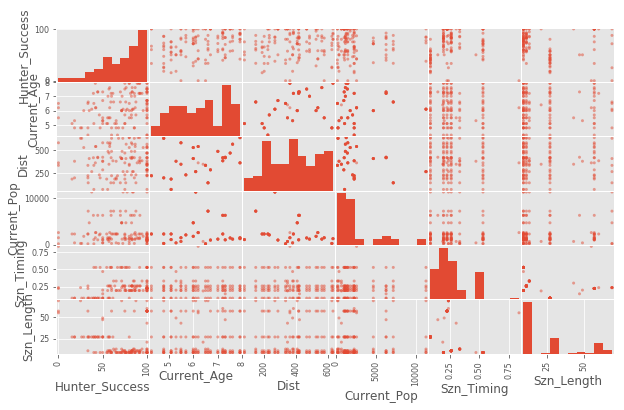

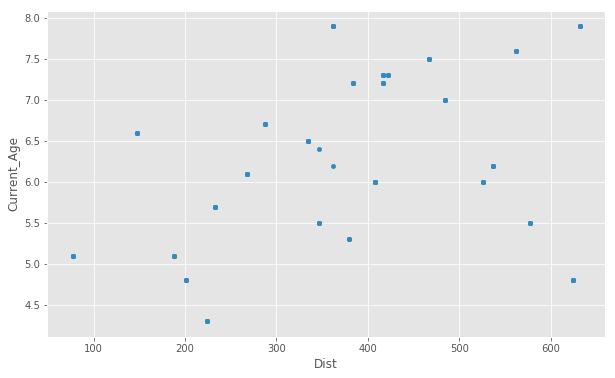

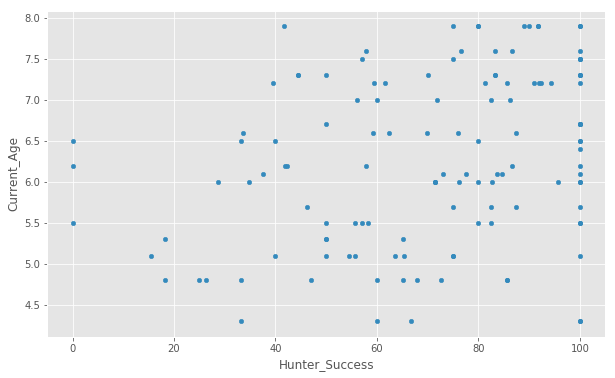

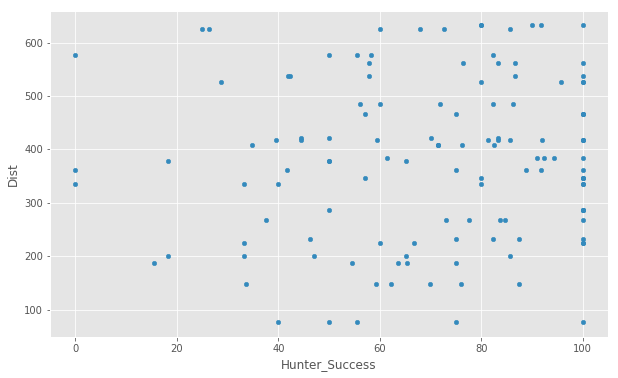

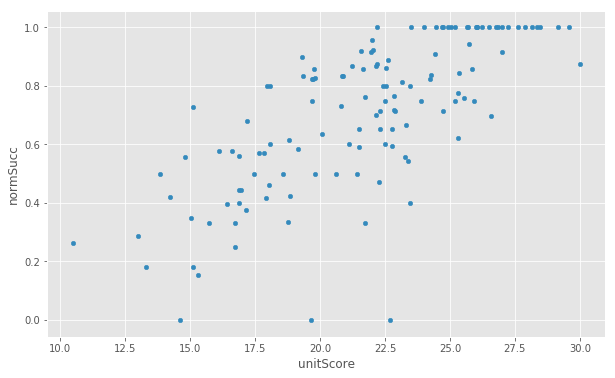

In [80]:
scatter_matrix(weap[['Hunter_Success','Current_Age','Dist','Current_Pop','Szn_Timing','Szn_Length']])
weap.plot.scatter('Dist','Current_Age')
weap.plot.scatter('Hunter_Success','Current_Age')
weap.plot.scatter('Hunter_Success','Dist')

scoreFrame.plot.scatter('unitScore','normSucc')

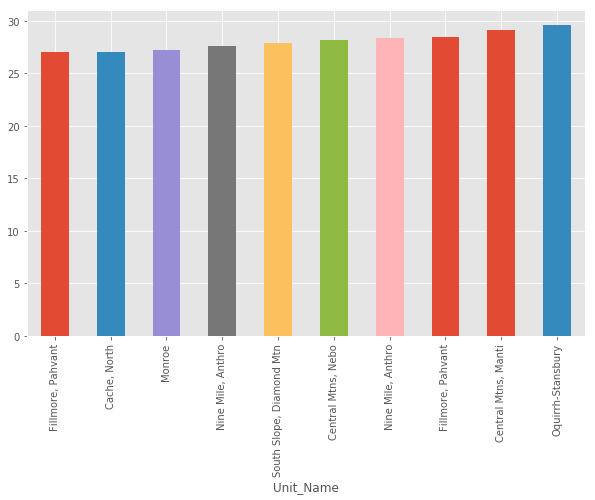

In [82]:
scoreFrame['unitScore'][-11:-1].plot(kind='bar')

### Description of Project 

We have acquired most of our data, however during the process we came accross additional data that still needs to be acquired and added to our dataset. We would like to get draw odds of limited entry units, which are only available via pdf right now. We can either manually get data from the pdf, but we are also in the process of contacting the Utah DWR to get the data in a csv form. <br>

Another piece of data that would be nice to acquire is the % of unit that is public land. In the DWR app that we scraped, you can apply filters as map layers that contain public/private land, so this information might be gleanable. 
<br>
If we cannot get this information, then our prject will be a few variables shy of what we proposed.  In that same vein, we haven't figured out a way to get geographical data to show how far each unit is from salt lake city, though we will look into that further as we progress. 

<br>
An important aspect about the dataset is the inclusion of multiple weapon type for each region. Repeats in data are a reflection of this fact and are included in the data set due to the limited permits alloted per weapon type. Once that data is aquired (as mentioned above), the data will become useful. 
<br>
<br>
<br>
Depending if we can get additional data to make our set more robust, we might add the same data we have, but for different species of animals (deer, pronghorn, etc). This will, for the purposes of the project, give us a larger dataset to look at. 
<br>
<br>
Our final analysis will still involve weighting each variable subjectively so we can determine which hunt units are the best. We will also use regression analysis to predic hunter success as well. Another piece that will go into the analysis is we can use the el dataset as a training set, and see if we can predict hunter success in other species (our test sets).  

([<matplotlib.axis.YTick at 0x2430fe15fd0>,
 <a list of 8 Text yticklabel objects>)

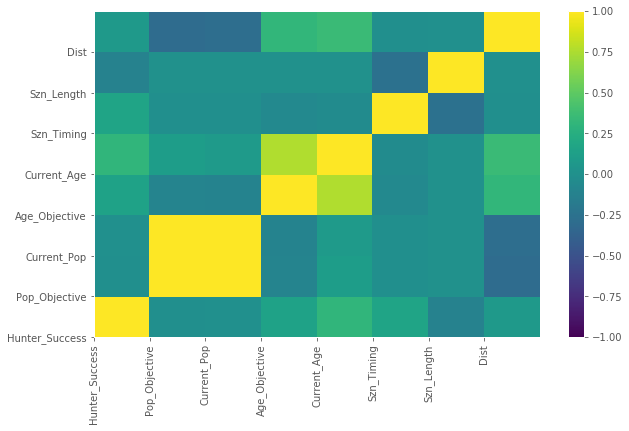

In [95]:
# visualize correlations as matrix

heatmap = plt.pcolor(correlation,vmin=-1,vmax=1)
plt.colorbar(heatmap)


plt.xticks(np.arange(8),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length','Dist'),rotation='vertical')
plt.yticks(np.arange(8),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length','Dist'),rotation='horizontal')

In [93]:
# Regression on hunt success

success =  sm.ols(formula = 'Hunter_Success ~ Current_Pop + Current_Age + Szn_Timing + Szn_Length + Dist', data=fd).fit()
success.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Hunter_Success   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     3.890
Date:                Sun, 21 Apr 2019   Prob (F-statistic):            0.00262
Time:                        13:36:47   Log-Likelihood:                -589.86
No. Observations:                 129   AIC:                             1192.
Df Residuals:                     123   BIC:                             1209.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.4396     14.432      1.208      0.229     -11.128      46.007
Current_Pop    -0.0005      0.001     -0.582      0.562      -0.002       0.001
Current_Age     8.5030      2.267      3.750      0.000       4.015      12.991
Szn_Timing     27.1869     14.826      1.834      0.069      -2.160      56.534
Szn_Length     -0.0932      0.115     -0.812      0.418      -0.320       0.134
Dist           -0.0108      0.016     -0.669      0.505      -0.043       0.021
==============================================================================
Omnibus:                        8.698   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.476
Skew:                          -0.578   Prob(JB):                       0.0144
Kurtosis:                       3.490   Cond. No.                     3.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""